<a href="https://colab.research.google.com/github/marcusaxelsson1/Advanced_NN/blob/main/HWC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --pre deeptrack
!pip install --pre deeplay
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.9/203.9 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.0/292.0 kB 8.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 14.3 MB/s eta 0:00:00
  Created wheel for pint: filename=Pint-0.19.2-py3-none-any.whl size=231000 sha256=b1988e40382f98da10c26283042f8262de23c3ec0a263e09b0768a1ed8fe182d
  Stored in directory: /root/.cache/pip/wheels/eb/00/87/c216aa83b91597845d9fec6fcd9dbe31c945a25d968dd4765a
  Created wheel for lazy-import: filename=lazy_import-0.2.2-py2.py3-none-any.whl size=16494 sha256=090a219c7b76fbfd6cb7805073b94b9b6ff227be797e1390ffbde75dfa826788
  Stored in directory: /root/.cache/pip/wheels/89/c9/fe/406995d79062aa583b3da5a6e5

### **Getting data from Deeptrack**

In [2]:
import deeptrack as dt
import numpy as np

IMAGE_SIZE = 64
sequence_length = 10  # Number of frames per sequence
MIN_SIZE = 0.5e-6
MAX_SIZE = 1.5e-6
MAX_VEL = 10  # Maximum velocity. The higher the trickier!
MAX_PARTICLES = 3  # Max number of particles in each sequence. The higher the trickier!

# Defining properties of the particles
particle = dt.Sphere(
    intensity=lambda: 10 + 10 * np.random.rand(),
    radius=lambda: MIN_SIZE + np.random.rand() * (MAX_SIZE - MIN_SIZE),
    position=lambda: IMAGE_SIZE * np.random.rand(2),
    vel=lambda: MAX_VEL * np.random.rand(2),
    position_unit="pixel",
)

# Defining an update rule for the particle position
def get_position(previous_value, vel):

    newv = previous_value + vel
    for i in range(2):
        if newv[i] > 63:
            newv[i] = 63 - np.abs(newv[i] - 63)
            vel[i] = -vel[i]
        elif newv[i] < 0:
            newv[i] = np.abs(newv[i])
            vel[i] = -vel[i]
    return newv


particle = dt.Sequential(particle, position=get_position)

# Defining properties of the microscope
optics = dt.Fluorescence(
    NA=1,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    magnification=10,
    resolution=(1e-6, 1e-6, 1e-6),
    wavelength=633e-9,
)

# Combining everything into a dataset.
# Note that the sequences are flipped in different directions, so that each unique sequence defines
# in fact 8 sequences flipped in different directions, to speed up data generation
sequential_images = dt.Sequence(
    optics(particle ** (lambda: 1 + np.random.randint(MAX_PARTICLES))),
    sequence_length=sequence_length,
)
dataset = sequential_images >> dt.FlipUD() >> dt.FlipDiagonal() >> dt.FlipLR()

# Getting just two images for pretraining the CNN
two_images = dt.Sequence(
    optics(particle ** (lambda: 1 + np.random.randint(MAX_PARTICLES))),
    sequence_length=2,
)
two_img_dataset = two_images >> dt.FlipUD() >> dt.FlipDiagonal() >> dt.FlipLR()

### **Exporing dataset**

In [3]:
# Generate a single batch of images
batch = dataset.update()()

# Get unique pixel values
unique_values = np.unique(batch)
print(unique_values)
print(len(unique_values))
print(np.max(unique_values))

# Check if the unique pixel values are binary
is_binary = len(unique_values) == 2 and (0 in unique_values) and (1 in unique_values)

if is_binary:
    print("The pixel values are binary (0 and 1).")
else:
    print("The pixel values are not binary.")

[2.06318837e-02 2.06499805e-02 2.07008643e-02 ... 3.14617521e+01
 3.14623184e+01 3.14654374e+01]
40960
31.465437392217105
The pixel values are not binary.


### **Plotting the images**

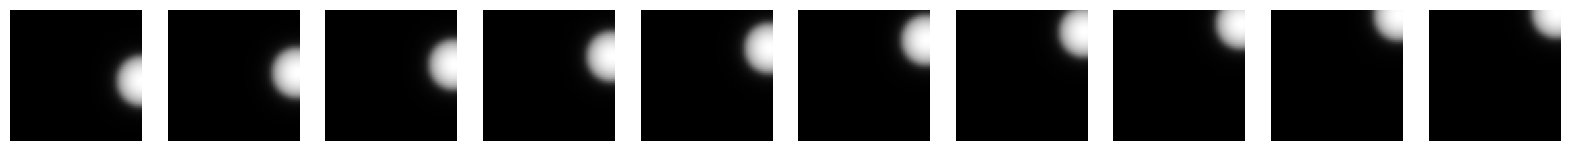

In [4]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def plot_images(images):
    # Check if the input is a list of numpy arrays
    if isinstance(images, list):
        num_images = len(images)
        fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))  # Adjust figure size as needed
        for i, img in enumerate(images):
            if img.ndim == 3 and img.shape[2] == 1:  # [H, W, 1] images
                ax = axes[i] if num_images > 1 else axes
                ax.imshow(img.squeeze(), cmap='gray')  # Squeeze to remove channel dim if it's 1
                ax.axis('off')
            else:
                raise ValueError("Image format not supported or needs additional handling for more channels.")

    # Check if the input is a PyTorch tensor
    elif isinstance(images, torch.Tensor):
        if images.dim() == 4:  # Batch of images [N, C, H, W]
            images = images.detach().cpu().numpy()  # Convert to numpy
            num_images = images.shape[0]
            fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))  # Adjust figure size as needed
            for i, img in enumerate(images):
                img = img.squeeze() if img.shape[0] == 1 else np.transpose(img, (1, 2, 0))
                ax = axes[i] if num_images > 1 else axes
                ax.imshow(img, cmap='gray' if img.ndim == 2 else None)
                ax.axis('off')
        else:
            raise ValueError("Tensor dimension not supported for visualization.")
    else:
        raise ValueError("Unsupported data type for the images.")

# Example of how to use the function:
# Assuming 'batch' is a list of numpy arrays from dataset.update()
plot_images(batch)

### **Creating Datasets and DataLoaders**

In [5]:
import torch
from torch.utils.data import Dataset
import math
from torch.utils.data import DataLoader
import numpy as np

def generate_data(dataset, size = 256):
  data = []
  for i in range(math.floor(size/2)):
    data += dataset.update()()
  return data

#train_df = generate_data(two_img_dataset, size = 256)
#print(len(test_data))
#plot_images(test_data[:16])

import torch
from torch.utils.data import Dataset
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, pregenerated_data):
      # Calculate mean and standard deviation for z-score normalization
        all_data = np.concatenate([image.flatten() for image in pregenerated_data])
        self.mean = np.mean(all_data)
        self.std = np.std(all_data)

        # Normalize images
        self.data = [
            torch.tensor((np.moveaxis(image, -1, 0).copy() - self.mean) / self.std, dtype=torch.float32)
            for image in pregenerated_data
        ]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Assuming two_img_dataset and generate_data are properly defined and used as before
train_df = generate_data(two_img_dataset, size = 256)
train_data = CustomDataset(train_df)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

val_df = generate_data(two_img_dataset, size = 256)
val_data = CustomDataset(val_df)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)

test_df = generate_data(two_img_dataset, size = 256)
test_data = CustomDataset(test_df)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)




## **Checking how the images looks and that the dimensions are correct**

torch.Size([1, 64, 64])


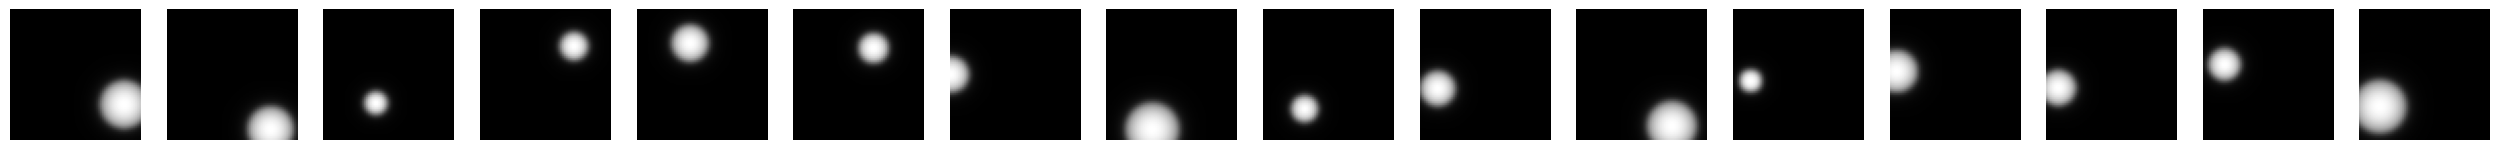

In [6]:
# Fetch one batch from the DataLoader
for images in train_loader:
    # Assuming plot_images is defined to handle a batch of images
    print(images[0].shape)  # Pass the tensor directly if your function handles tensor input
    plot_images(images)
    break  # Exit after the first batch


### **Creating the CNN**

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

class Model8(nn.Module):
    def __init__(self):
        super(Model8, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),   # [batch, 16, H/2, W/2]
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # [batch, 32, H/4, W/4]
            nn.ReLU(True),
            nn.Conv2d(32, 32, 3, stride=2, padding=1),  # [batch, 32, H/8, W/8]
            nn.ReLU(True),
            nn.Conv2d(32, 8, 3, stride=2, padding=1),   # [batch, 8, H/16, W/16]
            nn.ReLU(True)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 32, 3, stride=2, padding=1, output_padding=1),    # [batch, 32, H/8, W/8]
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1, output_padding=1),   # [batch, 32, H/4, W/4]
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),   # [batch, 16, H/2, W/2]
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),    # [batch, 1, H, W]
            #nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

class Model64(nn.Module):
    def __init__(self):
        super(Model64, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # [batch, 16, H/2, W/2]
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # [batch, 32, H/4, W/4]
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # [batch, 64, H/8, W/8]
            nn.ReLU(True)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # [batch, 32, H/4, W/4]
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # [batch, 16, H/2, W/2]
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),   # [batch, 1, H, W]
            #nn.ReLU()  # Assuming the input is scaled between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

class Model128(nn.Module):
    def __init__(self):
        super(Model128, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 128, 3, stride=2, padding=1),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            #nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

class Model256(nn.Module):
    def __init__(self):
        super(Model256, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 64, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 256, 3, stride=2, padding=1),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            #nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

class Model512(nn.Module):
    def __init__(self):
        super(Model512, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 128, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, 512, 3, stride=2, padding=1),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 128, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            #nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### **Training the models**

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

def train_nn(model, val_loader, optimizer, loss_fn, num_epochs):

    # Store losses to return
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total_train_loss = 0

        train_df = generate_data(two_img_dataset, size = 256)
        train_data = CustomDataset(train_df)
        train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

        for images in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, images)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * images.size(0)

        # Calculate average training loss for the epoch
        avg_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        total_val_loss = 0
        with torch.no_grad():
            for images in val_loader:
                outputs = model(images)
                loss = loss_fn(outputs, images)
                total_val_loss += loss.item() * images.size(0)

        # Calculate average validation loss for the epoch
        avg_val_loss = total_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)

        # Print losses for the epoch
        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    return train_losses, val_losses


### **Models with different bottleneck sizes**

In [13]:
# Create the model with bottleneck 64
model8 = Model8()

In [14]:
# Define the optimizer and loss function
optimizer = optim.Adam(model8.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Number of epochs to train
num_epochs = 10

# Train the network
train_losses8, val_losses8 = train_nn(model8, val_loader, optimizer, loss_fn, num_epochs)

Epoch 1/10 - Train Loss: 1.0021, Val Loss: 0.9838
Epoch 2/10 - Train Loss: 0.8300, Val Loss: 0.5398
Epoch 3/10 - Train Loss: 0.3540, Val Loss: 0.2082
Epoch 4/10 - Train Loss: 0.1535, Val Loss: 0.1311
Epoch 5/10 - Train Loss: 0.1197, Val Loss: 0.0925
Epoch 6/10 - Train Loss: 0.0807, Val Loss: 0.0732
Epoch 7/10 - Train Loss: 0.0768, Val Loss: 0.0619
Epoch 8/10 - Train Loss: 0.0572, Val Loss: 0.0496
Epoch 9/10 - Train Loss: 0.0464, Val Loss: 0.0420
Epoch 10/10 - Train Loss: 0.0409, Val Loss: 0.0413


In [15]:
# Create the model with bottleneck 64
model64 = Model64()

In [21]:
# Define the optimizer and loss function
optimizer = optim.Adam(model64.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Number of epochs to train
num_epochs = 10

# Train the network
train_losses64, val_losses64 = train_nn(model64, val_loader, optimizer, loss_fn, num_epochs)

Epoch 1/10 - Train Loss: 0.9064, Val Loss: 0.5374
Epoch 2/10 - Train Loss: 0.3513, Val Loss: 0.1943
Epoch 3/10 - Train Loss: 0.1295, Val Loss: 0.0998
Epoch 4/10 - Train Loss: 0.0692, Val Loss: 0.0659
Epoch 5/10 - Train Loss: 0.0439, Val Loss: 0.0436
Epoch 6/10 - Train Loss: 0.0351, Val Loss: 0.0338
Epoch 7/10 - Train Loss: 0.0294, Val Loss: 0.0254
Epoch 8/10 - Train Loss: 0.0212, Val Loss: 0.0253
Epoch 9/10 - Train Loss: 0.0202, Val Loss: 0.0202
Epoch 10/10 - Train Loss: 0.0150, Val Loss: 0.0155


In [16]:
model128 = Model128()

In [ ]:
# Define the optimizer and loss function
optimizer = optim.Adam(model128.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Number of epochs to train
num_epochs = 10

# Train the network
train_losses128, val_losses128 = train_nn(model128, val_loader, optimizer, loss_fn, num_epochs)

Epoch 1/10 - Train Loss: 0.7812, Val Loss: 0.3583
Epoch 2/10 - Train Loss: 0.2240, Val Loss: 0.1064
Epoch 3/10 - Train Loss: 0.0857, Val Loss: 0.0622
Epoch 4/10 - Train Loss: 0.0514, Val Loss: 0.0415
Epoch 5/10 - Train Loss: 0.0379, Val Loss: 0.0281
Epoch 6/10 - Train Loss: 0.0244, Val Loss: 0.0221
Epoch 7/10 - Train Loss: 0.0218, Val Loss: 0.0184
Epoch 8/10 - Train Loss: 0.0147, Val Loss: 0.0122
Epoch 9/10 - Train Loss: 0.0122, Val Loss: 0.0105
Epoch 10/10 - Train Loss: 0.0115, Val Loss: 0.0099


In [17]:
model256 = Model256()

In [ ]:
# Define the optimizer and loss function
optimizer = optim.Adam(model256.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Number of epochs to train
num_epochs = 10

# Train the network
train_losses256, val_losses256 = train_nn(model256, val_loader, optimizer, loss_fn, num_epochs)

Epoch 1/10 - Train Loss: 0.8272, Val Loss: 0.3988
Epoch 2/10 - Train Loss: 0.2267, Val Loss: 0.1062
Epoch 3/10 - Train Loss: 0.0871, Val Loss: 0.0733
Epoch 4/10 - Train Loss: 0.0606, Val Loss: 0.0420
Epoch 5/10 - Train Loss: 0.0418, Val Loss: 0.0292
Epoch 6/10 - Train Loss: 0.0258, Val Loss: 0.0208
Epoch 7/10 - Train Loss: 0.0193, Val Loss: 0.0146
Epoch 8/10 - Train Loss: 0.0138, Val Loss: 0.0125
Epoch 9/10 - Train Loss: 0.0121, Val Loss: 0.0097
Epoch 10/10 - Train Loss: 0.0089, Val Loss: 0.0085


In [18]:
model512 = Model512()

In [ ]:
# Define the optimizer and loss function
optimizer = optim.Adam(model512.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Number of epochs to train
num_epochs = 10

# Train the network
train_losses512, val_losses512 = train_nn(model512, val_loader, optimizer, loss_fn, num_epochs)

Epoch 1/10 - Train Loss: 0.3677, Val Loss: 0.0861
Epoch 2/10 - Train Loss: 0.0595, Val Loss: 0.0337
Epoch 3/10 - Train Loss: 0.0296, Val Loss: 0.0210
Epoch 4/10 - Train Loss: 0.0194, Val Loss: 0.0137
Epoch 5/10 - Train Loss: 0.0107, Val Loss: 0.0078
Epoch 6/10 - Train Loss: 0.0077, Val Loss: 0.0063
Epoch 7/10 - Train Loss: 0.0062, Val Loss: 0.0042
Epoch 8/10 - Train Loss: 0.0047, Val Loss: 0.0033
Epoch 9/10 - Train Loss: 0.0036, Val Loss: 0.0030
Epoch 10/10 - Train Loss: 0.0034, Val Loss: 0.0034


### **Visualizing the results**

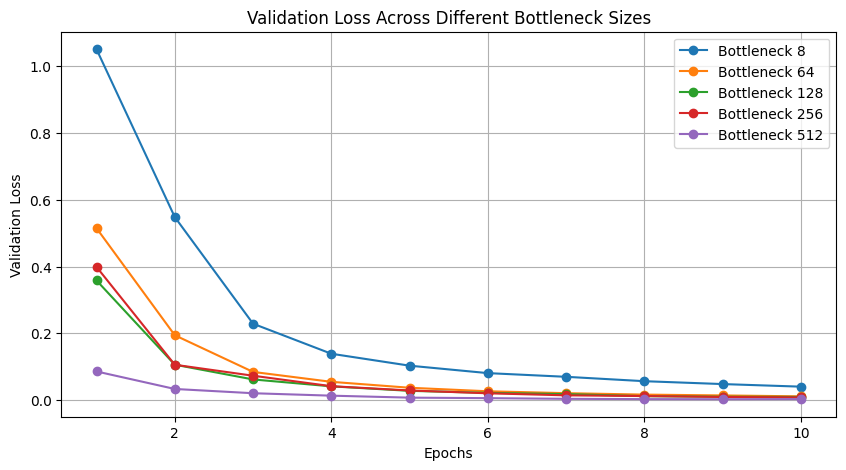

In [ ]:
# Assuming all models were trained for the same number of epochs
epochs = range(1, len(val_losses8) + 1)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_losses8, label='Bottleneck 8', marker='o')
plt.plot(epochs, val_losses64, label='Bottleneck 64', marker='o')
plt.plot(epochs, val_losses128, label='Bottleneck 128', marker='o')
plt.plot(epochs, val_losses256, label='Bottleneck 256', marker='o')
plt.plot(epochs, val_losses512, label='Bottleneck 512', marker='o')

plt.title('Validation Loss Across Different Bottleneck Sizes')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

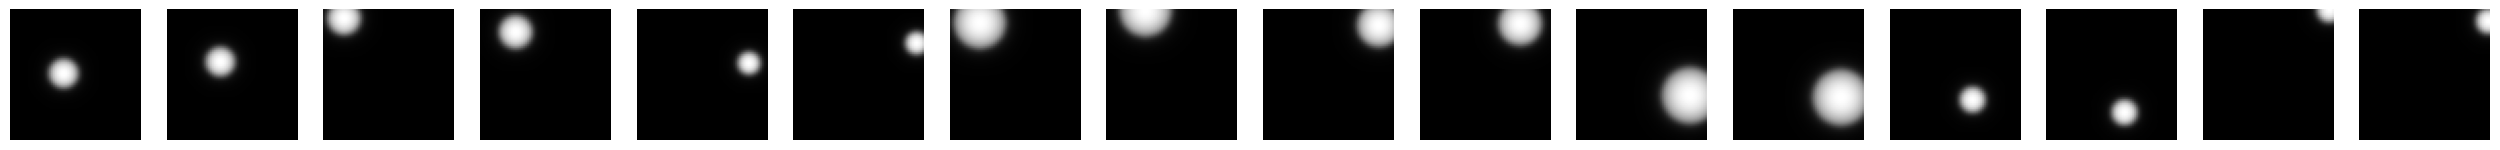

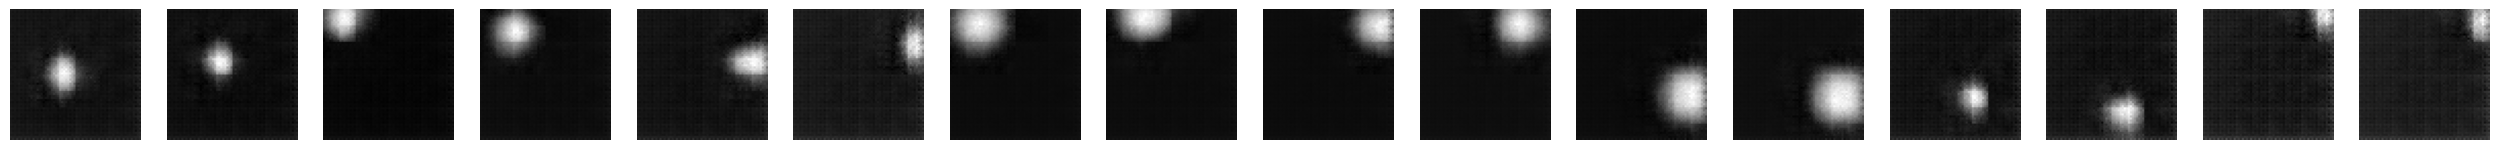

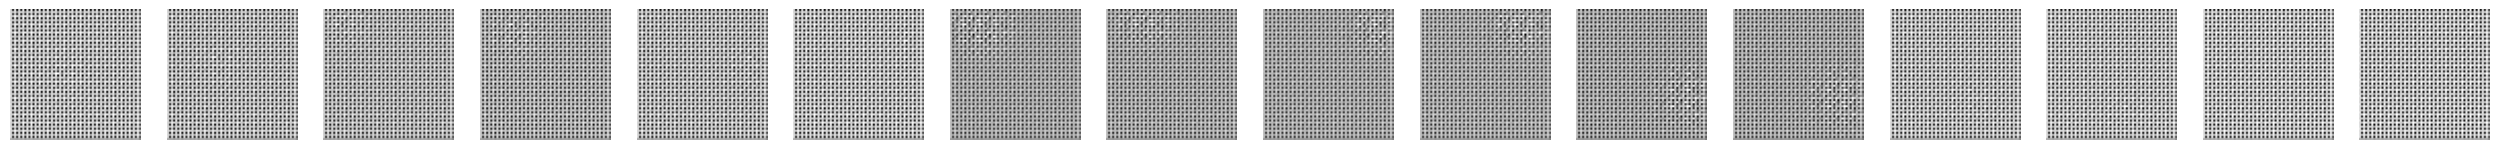

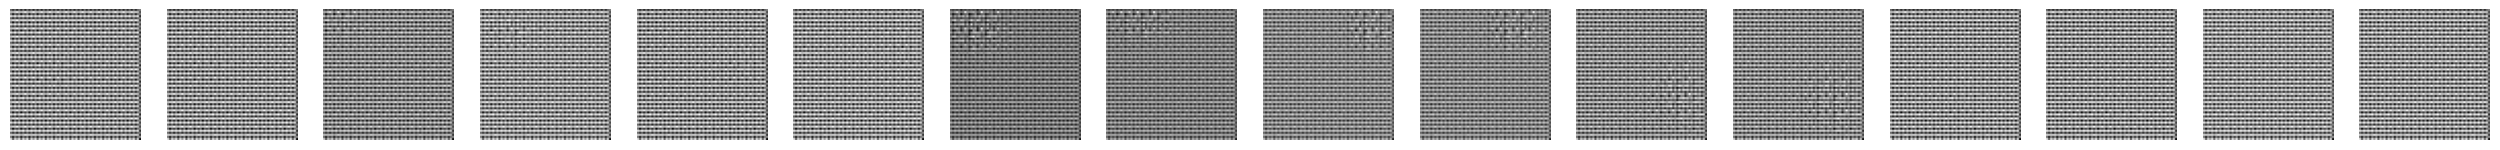

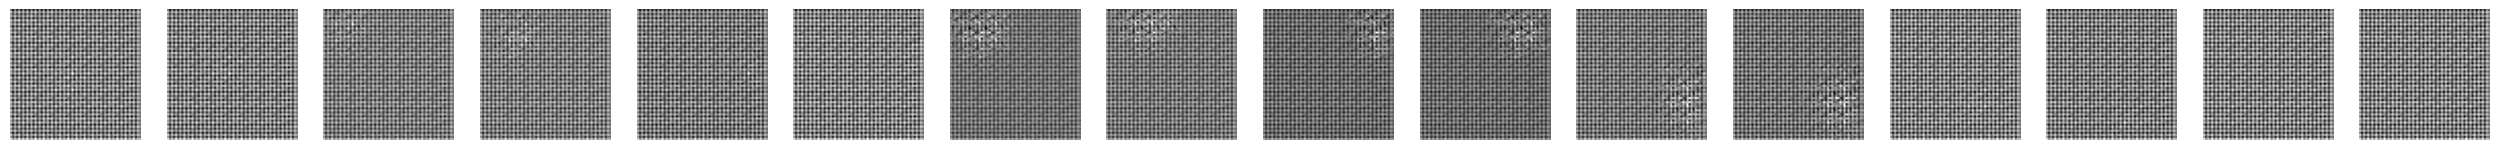

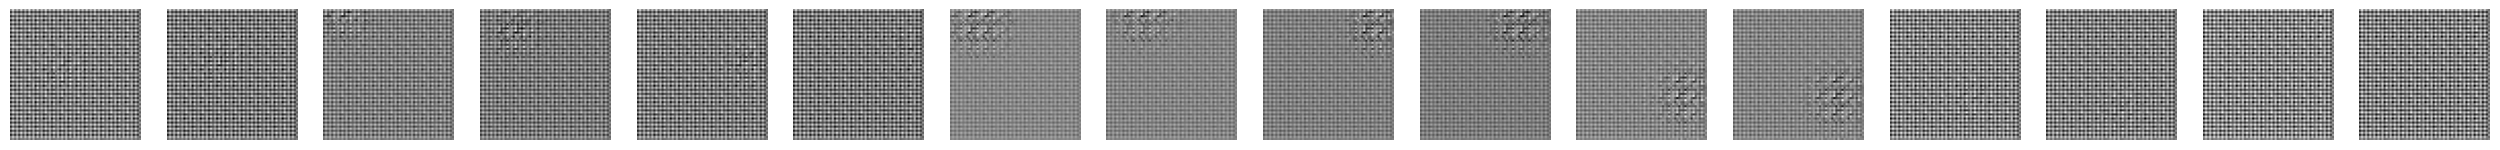

In [19]:
# Process images from test_loader
with torch.no_grad():
    for images in test_loader:

        plot_images(images)

        outputs8 = model8(images)
        plot_images(outputs8)

        outputs64 = model64(images)
        plot_images(outputs64)

        outputs128 = model128(images)
        plot_images(outputs128)

        outputs256 = model256(images)
        plot_images(outputs256)

        outputs512 = model512(images)
        plot_images(outputs512)

        break  # Remove break to process more batches

### **Transformer Encoder**

In [20]:
import torch
import torch.nn as nn
from einops import rearrange, repeat

class PatchEmbedding(nn.Module):
    def __init__(self, height, width, im_channels, emb_dim, patch_emb_drop, patch_size):
        super().__init__()
        self.patch_height = patch_size
        self.patch_width = patch_size
        num_patches = (height // self.patch_height) * (width // self.patch_width)
        patch_dim = im_channels * self.patch_height * self.patch_width

        self.patch_embeddings = nn.Linear(patch_dim, emb_dim)  # Embed each patch
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, emb_dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim))
        self.patch_emb_dropout = nn.Dropout(patch_emb_drop)

    def forward(self, x):
      batch_size = x.shape[0]
      # Rearrange the input into patches and then project them into the embedding dimension
      x = rearrange(x, 'b c (h ph) (w pw) -> b (h w) (ph pw c)', ph=self.patch_height, pw=self.patch_width)
      x = self.patch_embeddings(x)  # Linear transformation

      # Adjust repeat pattern here
      cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=batch_size)
      x = torch.cat((cls_tokens, x), dim=1)

      x += self.pos_embed
      x = self.patch_emb_dropout(x)

      return x

# Example configuration (Adjusted for your specific dimensions)
test = PatchEmbedding(64, 64, 1, 512, 0.1, 8)
# Assuming 'train_loader' yields batches of shape [batch_size, channels, height, width]

for batch in train_loader:
    out = test(batch)  # Ensure 'batch' provides the correct tensor shape
    break

print(out.shape)


torch.Size([16, 65, 512])


In [33]:
class EncoderBlock(nn.Module):
    def __init__(self, latent_size, num_heads, dropout=0.1):
        super(EncoderBlock, self).__init__()
        self.norm1 = nn.LayerNorm(latent_size)
        self.multihead = nn.MultiheadAttention(latent_size, num_heads, dropout=dropout)
        self.ffn = nn.Sequential(
            nn.Linear(latent_size, latent_size * 4),
            nn.GELU(),
            nn.Linear(latent_size * 4, latent_size),
            nn.Dropout(dropout)
        )
        self.norm2 = nn.LayerNorm(latent_size)

    def forward(self, x):
        norm = self.norm1(x)
        attention_output, attn_weights = self.multihead(norm, norm, norm)
        x = x + attention_output
        norm2 = self.norm2(x)
        x = x + self.ffn(norm2)
        return x, attn_weights

class Vit(nn.Module):
    def __init__(self, img_height, img_width, img_channels, emb_dim, patch_size, num_encoders, num_heads, dropout=0.1):
        super(Vit, self).__init__()
        self.embedding = PatchEmbedding(img_height, img_width, img_channels, emb_dim, dropout, patch_size)
        self.encoders = nn.ModuleList([EncoderBlock(emb_dim, num_heads, dropout) for _ in range(num_encoders)])
        self.MLP = nn.Sequential(
            nn.LayerNorm(emb_dim),
            nn.Linear(emb_dim, emb_dim),
            nn.Linear(emb_dim, emb_dim)
        )

    def forward(self, input_data):
        x = self.embedding(input_data)
        attention_weights = []
        for encoder in self.encoders:
            x, weights = encoder(x)
            attention_weights.append(weights)
        x = self.MLP(x)
        return x, attention_weights


In [34]:
# Example configuration
vit_model = Vit(img_height=64, img_width=64, img_channels=1, emb_dim=128, patch_size=8, num_encoders=6, num_heads=8, dropout=0.1)

# Assuming 'train_loader' yields batches of shape [batch_size, channels, height, width]
for batch in train_loader:
    images = batch  # Adjust according to how your data is structured
    outputs, attn_weights = vit_model(images)
    break

print(outputs.shape)
# Example output shape should be [batch_size, num_patches + 1, emb_dim] -> [batch_size, 65, emb_dim]

torch.Size([16, 65, 128])


In [35]:
encoder = model8.encoder

for batch in train_loader:
   encoded_imgs = encoder(batch)

encoded_imgs.shape

torch.Size([16, 8, 4, 4])

In [36]:
class ViTWithDecoder(nn.Module):
    def __init__(self, img_height, img_width, img_channels, emb_dim, patch_size, num_encoders, num_heads, dropout=0.1, initial_channels=256, output_channels=1):
        super(ViTWithDecoder, self).__init__()
        self.vit = Vit(img_height, img_width, img_channels, emb_dim, patch_size, num_encoders, num_heads, dropout)
        self.decoder = model8.decoder  # Assuming 'model64.decoder' accepts [batch_size, 8, 4, 4]

    def forward(self, input_data):
        vit_outputs, attn_weights = self.vit(input_data)
        cls_tokens = vit_outputs[:, 0, :]  # Extract classification tokens
        #print(cls_tokens.shape)  # Debug print to check shape
        cls_tokens_reshaped = cls_tokens.reshape(-1, 8, 4, 4)  # Correctly reshape tokens
        #print(cls_tokens_reshaped.shape)
        decoded_output = self.decoder(cls_tokens_reshaped)
        return decoded_output, attn_weights

# Example usage
model = ViTWithDecoder(img_height=64, img_width=64, img_channels=1, emb_dim=128, patch_size=8, num_encoders=1, num_heads=4, dropout=0.1, initial_channels=256, output_channels=1)

for batch in train_loader:
    images = batch  # Adjust according to your data structure
    decoded_images, attn_weights = model(images)
    break

print(decoded_images.shape)  # Should print the shape of the output from the decoder

torch.Size([16, 1, 64, 64])


In [37]:
import torch
from torch.utils.data import DataLoader
import torch.nn.utils as torch_utils

def train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=25):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for inputs in train_loader:
            inputs = inputs.to(device)
            optimizer.zero_grad()
            outputs, _ = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()

            optimizer.step()
            total_loss += loss.item() * inputs.size(0)

        avg_train_loss = total_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for inputs in val_loader:
                inputs = inputs.to(device)
                outputs, _ = model(inputs)
                loss = criterion(outputs, inputs)
                total_val_loss += loss.item() * inputs.size(0)

        avg_val_loss = total_val_loss / len(val_loader.dataset)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

# Example of using this function
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.MSELoss()  # Assuming reconstruction task
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_model(model, train_loader, val_loader, optimizer, criterion, device)

Epoch 1/25, Train Loss: 0.9967, Val Loss: 0.9966
Epoch 2/25, Train Loss: 0.9935, Val Loss: 0.9975
Epoch 3/25, Train Loss: 0.9924, Val Loss: 0.9983
Epoch 4/25, Train Loss: 0.9919, Val Loss: 0.9979
Epoch 5/25, Train Loss: 0.9918, Val Loss: 0.9972
Epoch 6/25, Train Loss: 0.9917, Val Loss: 0.9978
Epoch 7/25, Train Loss: 0.9919, Val Loss: 0.9975
Epoch 8/25, Train Loss: 0.9915, Val Loss: 0.9980
Epoch 9/25, Train Loss: 0.9915, Val Loss: 0.9975
Epoch 10/25, Train Loss: 0.9917, Val Loss: 0.9979
Epoch 11/25, Train Loss: 0.9916, Val Loss: 0.9977
Epoch 12/25, Train Loss: 0.9916, Val Loss: 0.9977
Epoch 13/25, Train Loss: 0.9914, Val Loss: 0.9975
Epoch 14/25, Train Loss: 0.9916, Val Loss: 0.9975
Epoch 15/25, Train Loss: 0.9915, Val Loss: 0.9982
Epoch 16/25, Train Loss: 0.9918, Val Loss: 0.9973
Epoch 17/25, Train Loss: 0.9916, Val Loss: 0.9979
Epoch 18/25, Train Loss: 0.9912, Val Loss: 0.9981
Epoch 19/25, Train Loss: 0.9914, Val Loss: 0.9983
Epoch 20/25, Train Loss: 0.9913, Val Loss: 0.9978
Epoch 21/